In [1]:
# to handle dataset
import pandas as pd
import datetime as dt
import numpy as np

#to visualize
import matplotlib.pyplot as plt
%matplotlib inline

#ols regression 
import statsmodels.formula.api as smf

# feature scaling
from sklearn.preprocessing import StandardScaler

#to crawl stock data
import pandas_datareader.data as web

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
start = dt.datetime(2018,1,1)
end = dt.datetime(2020,1,1)
# end = dt.datetime.now() 

asii = web.DataReader("ASII.JK", 'yahoo', start,end)
dji = web.DataReader("^DJI",'yahoo',start,end)
nikkei = web.DataReader("^N225",'yahoo', start, end)
sp500 = web.DataReader("^GSPC",'yahoo', start, end)
hsi = web.DataReader("^HSI", 'yahoo',start, end)
ihsg = web.DataReader("^JKSE", 'yahoo', start, end)


## Step 1: Data Munging

In [4]:
#bind all stock market data into same dataframe
# df is the dataframe of our tradng model
# due to the timezone issues, we extract and calculate approriate stock market
#  data for analysis 
df = pd.DataFrame(index=asii.index)
#df['asii'] = np.log(asii['Open'].shift(-1)) - np.log(asii['Open'])
df['asii'] = asii['Open'].shift(-1) - asii['Open']
df['asii_lag1'] = df['asii'].shift(1)   
df['dji'] = dji['Open'] - dji['Open'].shift(1)
df['sp500'] = sp500['Open']- sp500['Open'].shift(1)
df['hsi'] = hsi['Open']- hsi['Close']
df['nikkei'] = nikkei['Open'] - nikkei['Close']
df['ihsg'] = ihsg['Open'] - ihsg['Open'].shift(1)
df['Price'] = asii['Open']
df.tail()

,asii,asii_lag1,dji,sp500,hsi,nikkei,ihsg,Price
Date,,,,,,,,
2019-12-20,150.0,-25.0,330.330078,31.010010,-36.798828,76.818359,-17.228027,6850.0
2019-12-23,-200.0,150.0,-116.861328,2.719971,118.208984,100.179688,52.510742,7000.0
2019-12-26,125.0,-200.0,-33.109375,1.750000,NaN,-137.220703,-6.611816,6800.0
2019-12-27,0.0,125.0,135.878906,20.030029,-191.759766,116.029297,18.509766,6925.0
2019-12-30,NaN,0.0,-20.580078,-7.139893,-68.910156,114.310547,7.565918,6925.0


In [5]:
#checking for NaN Values in dataframe
df.isnull().mean()

asii         0.001927
asii_lag1    0.001927
dji          0.036609
sp500        0.036609
hsi          0.055877
nikkei       0.065511
ihsg         0.067437
Price        0.000000
dtype: float64

In [6]:
# use fillna() from dataframe to forwad filling the NaN values
# then we can drop the reminding Nan values
df = df.fillna(method='ffill')
df = df.dropna()

print(df.shape)

(516, 8)


## Step 2 : Split Data

In [7]:
# Split the data into train set and test set (out of sample)
train = df.iloc[0:300, :] 
test = df.iloc[300:516, :]

In [8]:
print(train.shape, test.shape)
train.head()

(300, 8) (216, 8)


,asii,asii_lag1,dji,sp500,hsi,nikkei,ihsg,Price
Date,,,,,,,,
2018-01-04,75.0,-175.0,114.410156,21.459961,-44.769531,-432.599609,-83.554199,8075.0
2018-01-05,150.0,75.0,150.060547,12.020020,79.218750,-71.529297,21.740234,8150.0
2018-01-08,0.0,150.0,193.480469,11.339844,-4.439453,-71.529297,74.904785,8300.0
2018-01-09,-25.0,0.0,3.650391,8.479980,-77.900391,98.980469,39.512207,8300.0
2018-01-10,0.0,-25.0,36.080078,-5.599854,-64.480469,44.611328,-12.956055,8275.0


## Step 3: Explore the train data set

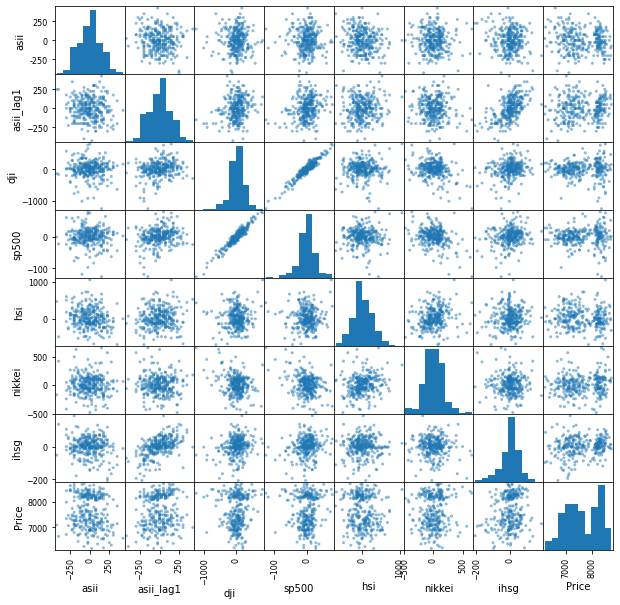

In [9]:
# generate scatter matrix among all stock markets to observe the association

from pandas.plotting import scatter_matrix
sm = scatter_matrix(train, figsize=(10, 10))

In [10]:
corr_array = train.iloc[:, :].corr()['asii']
print(corr_array)

asii         1.000000
asii_lag1   -0.078165
dji         -0.019627
sp500       -0.018205
hsi         -0.162841
nikkei      -0.031191
ihsg        -0.116322
Price       -0.115168
Name: asii, dtype: float64


In [11]:
formula = 'asii ~ asii_lag1 + dji + sp500 + hsi + nikkei + ihsg + Price'
lm = smf.ols(formula= formula, data=train).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   asii   R-squared:                       0.051
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     2.265
Date:                Sat, 11 Jul 2020   Prob (F-statistic):             0.0293
Time:                        20:25:41   Log-Likelihood:                -1904.1
No. Observations:                 300   AIC:                             3824.
Df Residuals:                     292   BIC:                             3854.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    193.7186     99.412      1.949      0.052      -1.935     389.373
asii_lag1     -0.0063      0.069     -0.092      0.927      -0.142       0.129
dji            0.0418      0.112      0.375      0.708      -0.178       0.261
sp500         -0.3430      1.071     -0.320      0.749      -2.452       1.766
hsi           -0.0923      0.032     -2.908      0.004      -0.155      -0.030
nikkei         0.0066      0.052      0.126      0.900      -0.097       0.110
ihsg          -0.2245      0.175     -1.283      0.201      -0.569       0.120
Price         -0.0254      0.013     -1.954      0.052      -0.051       0.000
==============================================================================
Omnibus:                        0.868   Durbin-Watson:                   2.031
Prob(Omnibus):                  0.648   Jarque-Bera (JB):                0.982
Skew:                          -0.107   Prob(JB):                        0.612
Kurtosis:                       2.819   Cond. No.                     9.40e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.4e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Step 4: Make Prediction

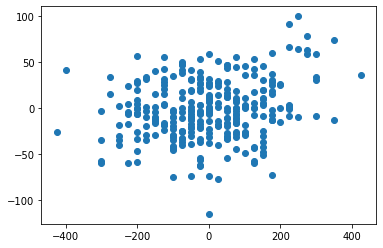

In [12]:
train['prediction'] = lm.predict(train)
test['prediction'] = lm.predict(test)
plt.scatter(train['asii'], train['prediction'])

## Step 5: Model Evaluation - Statistical Standard


In [13]:
# RMSE - Root Mean Squared Error, Adjusted R^2
def adjustedMetric(data, model, model_k, yname):
    data['yhat'] = model.predict(data)
    SST = ((data[yname] - data[yname].mean())**2).sum()
    SSR = ((data['yhat'] - data[yname].mean())**2).sum()
    SSE = ((data[yname] - data['yhat'])**2).sum()
    r2 = SSR/SST
    adjustR2 = 1 - (1-r2)*(data.shape[0] - 1)/(data.shape[0] -model_k -1)
    RMSE = (SSE/(data.shape[0] -model_k -1))**0.5
    return adjustR2, RMSE

In [14]:
def assessTable(test, train, model, model_k, yname):
    r2test, RMSEtest = adjustedMetric(test, model, model_k, yname)
    r2train, RMSEtrain = adjustedMetric(train, model, model_k, yname)
    assessment = pd.DataFrame(index=['R2', 'RMSE'], columns=['Train', 'Test'])
    assessment['Train'] = [r2train, RMSEtrain]
    assessment['Test'] = [r2test, RMSEtest]
    return assessment

In [15]:
# get the assesment table for model
assessTable(test,train,lm,7,'asii')

,Train,Test
R2,0.028762,0.040244
RMSE,139.979801,115.708961


## Step 6: Profit of Signal-based strategy

In [16]:
# Train
train['Order'] = [1 if sig >0 else -1 for sig in train['prediction']]
train['Profit'] = train['asii'] * train['Order']

train['Wealth'] =train['Profit'].cumsum()
print('Total profit made in train ', train['Profit'].sum())

Total profit made in train  7975.0


In [17]:
train.head()

,asii,asii_lag1,dji,sp500,hsi,nikkei,ihsg,Price,prediction,yhat,Order,Profit,Wealth
Date,,,,,,,,,,,,,
2018-01-04,75.0,-175.0,114.410156,21.459961,-44.769531,-432.599609,-83.554199,8075.0,6.925268,6.925268,1,75.0,75.0
2018-01-05,150.0,75.0,150.060547,12.020020,79.218750,-71.529297,21.740234,8150.0,-24.530081,-24.530081,-1,-150.0,-75.0
2018-01-08,0.0,150.0,193.480469,11.339844,-4.439453,-71.529297,74.904785,8300.0,-30.987744,-30.987744,-1,-0.0,-75.0
2018-01-09,-25.0,0.0,3.650391,8.479980,-77.900391,98.980469,39.512207,8300.0,-21.140012,-21.140012,-1,25.0,-50.0
2018-01-10,0.0,-25.0,36.080078,-5.599854,-64.480469,44.611328,-12.956055,8275.0,-3.978211,-3.978211,-1,-0.0,-50.0


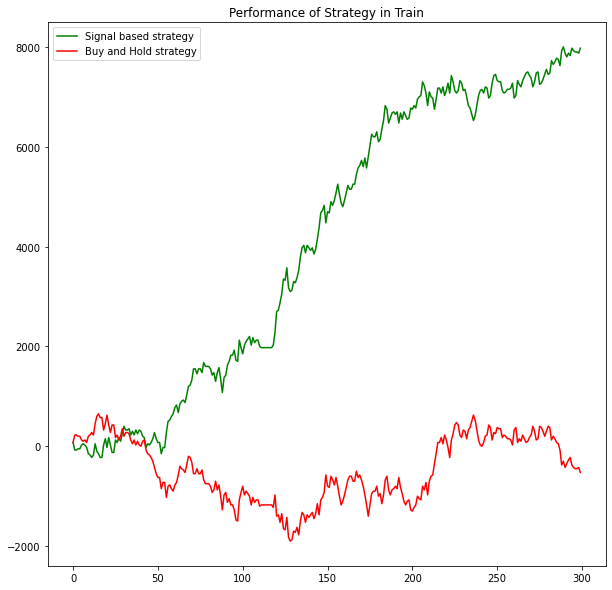

In [18]:
plt.figure(figsize=(10, 10))
plt.title('Performance of Strategy in Train')
plt.plot(train['Wealth'].values, color='green', label='Signal based strategy')
plt.plot(train['asii'].cumsum().values, color='red', label='Buy and Hold strategy')
plt.legend()
plt.show()

In [19]:
# Test
test['Order'] = [1 if sig >0 else  -1 for sig in test['prediction']]
test['Profit'] = test['asii'] * test['Order']

test['Wealth'] = test['Profit'].cumsum()
print ('Total profit made in Test: ', test['Profit'].sum())

Total profit made in Test:  3675.0


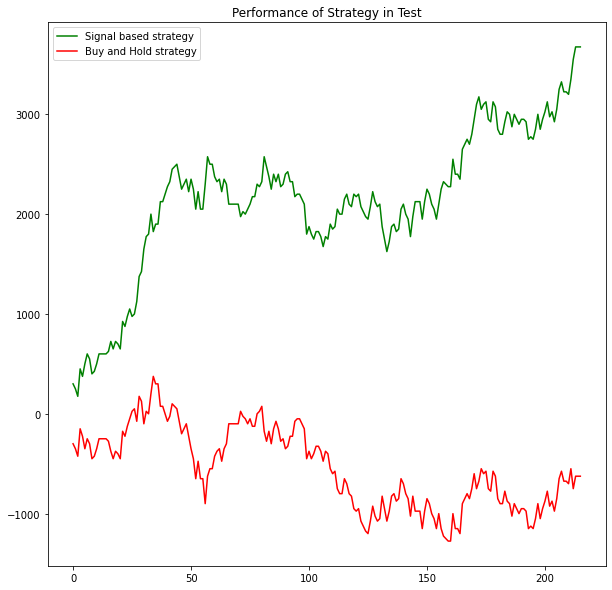

In [20]:
plt.figure(figsize=(10, 10))
plt.title('Performance of Strategy in Test')
plt.plot(test['Wealth'].values, color='green', label='Signal based strategy')
plt.plot(test['asii'].cumsum().values, color='red', label='Buy and Hold strategy')
plt.legend()
plt.show()

## Final Step: Evaluation of model - Practical Standard
There are 2 common practical standard to evaluate trading model performance. _Sharpe Ratio_ and _Maximum Drawdown_

In [21]:
train['Wealth'] = train['Wealth'] + train.loc[train.index[0],'Price']
test['Wealth'] = test['Wealth'] + test.loc[test.index[0],'Price']

In [22]:
# Sharpe Ratio on Train data
train['Return'] = np.log(train['Wealth']) - np.log(train['Wealth'].shift(1))
dailyr = train['Return'].dropna()

print('Daily Sharpe Ratio is ', dailyr.mean()/dailyr.std(ddof=1))
print('Yearly Sharpe Ratio is ', (252**0.5)*dailyr.mean()/dailyr.std(ddof=1))

Daily Sharpe Ratio is  0.18476842314089034
Yearly Sharpe Ratio is  2.9331077866100865


In [23]:
# Sharpe Ratio on Test data
test['Return'] = np.log(test['Wealth']) - np.log(test['Wealth'].shift(1))
dailyr = test['Return'].dropna()

print('Daily Sharpe Ratio is ', dailyr.mean()/dailyr.std(ddof=1))
print('Yearly Sharpe Ratio is ', (252**0.5)*dailyr.mean()/dailyr.std(ddof=1))

Daily Sharpe Ratio is  0.14221911551111438
Yearly Sharpe Ratio is  2.2576584679318636


In [24]:
# Maximum Drawdown in train data
train['Peak'] = train['Wealth'].cummax()
train['Drawdown'] = (train['Peak']- train['Wealth'])/train['Peak']
print('Maximum Drawdown in train is ', train['Drawdown'].max())

Maximum Drawdown in train is  0.06489675516224189


In [25]:
# Maximum Drawdown in test data
test['Peak'] = test['Wealth'].cummax()
test['Drawdown'] = (test['Peak']- test['Wealth'])/test['Peak']
print('Maximum Drawdown in train is ', test['Drawdown'].max())

Maximum Drawdown in train is  0.09382716049382717


In [26]:
##end here